# Pancancer Boxplot for PTEN and EGFR trans effects on MCM2

This notebook creates a boxplot for the trans effect of PTEN cnv deletions in 8 cancers. These 8 cancers were chosen because they have enough samples with PTEN cnv deletions to do a t-test. Only Ccrcc does not have enough samples with deletions. 

Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import gseapy as gp
import re
import sys 

import cptac
import cptac.utils as u

import sys
import plot_utils as p

Functions:

format_df prepares a data frame with PTEN proteomics and PTEN mutation types from get_genotype_all_vars.

format_pval_annotation is used to add marks to the boxplot. A star represents significant p-value and "ns" represents a nonsignificant p-value.

In [2]:
# Returns a dataframe with proteomics and mutation type

# all_prot: list of trans genes

def format_df(cancer_object, all_prot, gene_in = 'PTEN'):
    mut_type = cancer_object.get_genotype_all_vars(gene_in)
    
    if cancer_object.get_cancer_type() not in ('luad'):
        # Keep only tumor samples from proteomics
        prot_and_mutations = cancer_object.join_omics_to_mutations(
            mutations_genes = [gene_in], omics_df_name = 'proteomics', omics_genes = all_prot)
        # Reduce a multiindex 
        if isinstance(prot_and_mutations.keys(), pd.core.indexes.multi.MultiIndex):
            prot_and_mutations = cancer_object.reduce_multiindex(prot_and_mutations, levels_to_drop = 1)
        prot_and_mutations = prot_and_mutations[prot_and_mutations.Sample_Status == "Tumor"] # drop Normal samples

        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        mut_type = mut_type[['Mutation']] 
        prot_df = prot_and_mutations.iloc[:,:-4] # Keep only proteomics
        merged = prot_df.join(mut_type)
        
        # Keep only Wildtype and deletion
        compare = ['Wildtype_Tumor','Deletion']
        get = merged['Mutation'].isin(compare)
        del_wt = merged[get]
    
    
    # Luad has no somatic mutations for PTEN which changes some things
    else: 
        # get_genotype_all_vars add cnv data under the column PTEN
        mut_type = mut_type.drop(columns= gene_in)
        # different code because no somatic mutation data for pten (can't join to somatic mutations)
        omics = l.join_omics_to_omics(df1_name = 'CNV', df2_name='proteomics',genes1= gene_in, 
            genes2= all_prot)
        omics = l.reduce_multiindex(omics, levels_to_drop = 1, flatten = True)
        omics = omics.drop(columns='PTEN_CNV')
        # Get only tumor samples
        p = l.get_proteomics(tissue_type='tumor')
        tumor_ids = list(p.index)
        get = omics.index.isin(tumor_ids)
        omics = omics[get]
        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        merged = omics.join(mut_type) 
        # Keep only No_Mutation (wildtype) and deletion
        compare = ['No_Mutation','Deletion']
        get = merged['Mutation'].isin(compare)
        del_wt = merged[get]
        del_wt['Mutation'] = np.where(
            del_wt['Mutation'] == 'No_Mutation', 'Wildtype_Tumor', 'Deletion')

    return del_wt


In [3]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")


# Step 1: Create data frames with PTEN cnv deletion and Proteomics

Each cancer needs a data frame containing only samples that have PTEN cnv deletions or PTEN wildtype tumors and PTEN proteomics.

First, load in cancer data sets from cptac. Note: Keep the variable names the same because they are used in format_df to reduce multiindexs found in certain cancer data sets. 

In [4]:
en = cptac.Endometrial()
h = cptac.Hnscc()
l = cptac.Luad()
ls = cptac.Lscc()
o = cptac.Ovarian()
c = cptac.Ccrcc()
col = cptac.Colon()
g = cptac.Gbm()
b = cptac.Brca()

cptac warning: The LUAD dataset is under publication embargo until July 01, 2020. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 3)


cptac warning: The GBM dataset is under publication embargo until March 01, 2021. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 8)


Next, use format_df to create the specific data frame for each cancer. Use wrap_ttest to test PTEN deletion vs. wildtype. 

# Gbm

In [6]:
def add_dual_mut_status(del_wt, prot_gene_col):    
    g_df = del_wt.iloc[:,1:]
    g_df['dual_mut_status'] = 'neither'

    for index, row in g_df.iterrows():
        if row[0] != 'Wildtype_Tumor' and row[1] != 'Wildtype_Tumor':
            row['dual_mut_status'] = 'both'
        elif row[0] == 'Wildtype_Tumor' and row[1] != 'Wildtype_Tumor':
            row['dual_mut_status'] = 'EGFR'
        elif row[0] != 'Wildtype_Tumor' and row[1] == 'Wildtype_Tumor':
            row['dual_mut_status'] = 'PTEN'

    del_wt = del_wt[[prot_gene_col]].join(g_df)
    return del_wt
    

In [8]:
gene = 'PTEN'
t_gene = 'MCM2'
g_del_wt = format_df(g, t_gene)

# add EGFR
mut_egfr = g.get_genotype_all_vars('EGFR')
g_del_wt = g_del_wt.join(mut_egfr[['Mutation']], lsuffix='_PTEN', rsuffix='_EGFR')

# Keep only Wildtype and amplification
compare = ['Wildtype_Tumor','Amplification']
get = g_del_wt['Mutation_EGFR'].isin(compare)
cnv_wt = g_del_wt[get]

g_df = add_dual_mut_status(cnv_wt, 'MCM2_proteomics')
    
print(g_df.dual_mut_status.value_counts())
g_df.head()

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 72 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 383)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: C3L-01834 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 383)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 82 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 11)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 83 samples 

both       61
neither    10
PTEN        7
EGFR        3
Name: dual_mut_status, dtype: int64


Name,MCM2_proteomics,Mutation_PTEN,Mutation_EGFR,dual_mut_status
Patient_ID,,,,
C3L-00104,0.865204,Deletion,Amplification,both
C3L-00674,-0.236399,Deletion,Amplification,both
C3L-00677,-0.093372,Deletion,Amplification,both
C3L-01040,-0.957693,Deletion,Amplification,both
C3L-01043,0.152897,Deletion,Amplification,both


In [9]:
# ttest for egfr amp and wt
keep = ['Wildtype_Tumor', 'Amplification']
bool_df = g_df['Mutation_EGFR'].isin(keep)
g_egfr_wt = g_df[bool_df]
print(g_egfr_wt.Mutation_EGFR.value_counts())

# t-test
cols = [t_gene+'_proteomics']
g_pval = u.wrap_ttest(g_egfr_wt, 'Mutation_EGFR', cols, return_all = True)
gp = g_pval['P_Value'][0]
g_pval

Amplification     64
Wildtype_Tumor    17
Name: Mutation_EGFR, dtype: int64


,Comparison,P_Value
0,MCM2_proteomics,0.079702


In [10]:
# t-test both vs wt
keep = ['neither', 'both']
bool_df = g_df['dual_mut_status'].isin(keep)
dual_df = g_df[bool_df]
print(dual_df.dual_mut_status.value_counts())

cols = [t_gene+'_proteomics']
dual_g_pval = u.wrap_ttest(dual_df, 'dual_mut_status', cols, return_all = True)
dual_gp = dual_g_pval['P_Value'][0]
dual_g_pval

both       61
neither    10
Name: dual_mut_status, dtype: int64


,Comparison,P_Value
0,MCM2_proteomics,0.006134


# Luad

In [11]:
l_del_wt = format_df(l, t_gene)

# add EGFR
l_mut_egfr = l.get_genotype_all_vars('EGFR')
l_del_wt = l_del_wt.join(l_mut_egfr[['Mutation']], lsuffix='_PTEN', rsuffix='_EGFR')

# Keep only Wildtype and amplification
compare = ['Wildtype_Tumor','Amplification']
get = l_del_wt['Mutation_EGFR'].isin(compare)
l_cnv_wt = l_del_wt[get]
    
l_df = add_dual_mut_status(l_cnv_wt, 'MCM2_proteomics')

cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: C3L-00001.N, C3L-00009.N, C3L-00080.N, C3L-00083.N, C3L-00093.N, C3L-00094.N, C3L-00095.N, C3L-00140.N, C3L-00144.N, C3L-00263.N, C3L-00279.N, C3L-00368.N, C3L-00412.N, C3L-00422.N, C3L-00510.N, C3L-00604.N, C3L-00893.N, C3L-00913.N, C3L-00973.N, C3L-01330.N, C3L-01632.N, C3L-01682.N, C3L-01683.N, C3L-01889.N, C3L-01890, C3L-01890.N, C3L-01924.N, C3L-02219.N, C3L-02345.N, C3L-02348.N, C3L-02350.N, C3L-02365.N, C3L-02508.N, C3L-02549.N, C3N-00167.N, C3N-00169.N, C3N-00175.N, C3N-00180.N, C3N-00199.N, C3N-00203.N, C3N-00217.N, C3N-00223.N, C3N-00293.N, C3N-00433.N, C3N-00546.N, C3N-00547.N, C3N-00549.N, C3N-00550.N, C3N-00551.N, C3N-00552.N, C3N-00556.N, C3N-00559.N, C3N-00560.N, C3N-00572.N, C3N-00574.N, C3N-00578.N, C3N-00579.N, C3N-00580.N, C3N-00704.N, C3N-00737.N, C3N-00738.N, C3N-00959.N, C3N-01016.N, C3N-01021.N, C3N-01023.N, C3N-01024.N, C3N-01030.N, C3N-01

In [12]:
# ttest for egfr amp and wt
keep = ['Wildtype_Tumor', 'Amplification']
bool_df = l_df['Mutation_EGFR'].isin(keep)
l_egfr_wt = l_df[bool_df]
print(l_egfr_wt.Mutation_EGFR.value_counts())

# t-test
cols = [t_gene+'_proteomics']
l_pval = u.wrap_ttest(l_egfr_wt, 'Mutation_EGFR', cols, return_all = True)
lp = l_pval['P_Value'][0]
l_pval

Wildtype_Tumor    51
Amplification     26
Name: Mutation_EGFR, dtype: int64


,Comparison,P_Value
0,MCM2_proteomics,0.879024


In [13]:
# t-test both vs neither
keep = ['neither', 'both']
bool_df = l_df['dual_mut_status'].isin(keep)
dual_df = l_df[bool_df]
print(dual_df.dual_mut_status.value_counts())

cols = [t_gene+'_proteomics']
dual_l_pval = u.wrap_ttest(dual_df, 'dual_mut_status', cols, return_all = True)
dual_lp = dual_l_pval['P_Value'][0]
dual_l_pval

neither    48
both        7
Name: dual_mut_status, dtype: int64


,Comparison,P_Value
0,MCM2_proteomics,0.547054


# Lscc

In [14]:
ls_del_wt = format_df(ls, t_gene)

# add EGFR
ls_mut_egfr = ls.get_genotype_all_vars('EGFR')
ls_del_wt = ls_del_wt.join(ls_mut_egfr[['Mutation']], lsuffix='_PTEN', rsuffix='_EGFR')

# Keep only Wildtype and amplification
compare = ['Wildtype_Tumor','Amplification']
get = ls_del_wt['Mutation_EGFR'].isin(compare)
ls_cnv_wt = ls_del_wt[get]
    
ls_df = add_dual_mut_status(ls_cnv_wt, 'MCM2_proteomics')

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 99 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 383)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 201 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 11)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 106 samples for the EGFR gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 383)


In [15]:
# ttest for egfr amp and wt
keep = ['Wildtype_Tumor', 'Amplification']
bool_df = ls_df['Mutation_EGFR'].isin(keep)
ls_egfr_wt = ls_df[bool_df]
print(ls_egfr_wt.Mutation_EGFR.value_counts())

# t-test
cols = [t_gene+'_proteomics']
ls_pval = u.wrap_ttest(ls_egfr_wt, 'Mutation_EGFR', cols, return_all = True)
lsp = ls_pval['P_Value'][0]
ls_pval

Wildtype_Tumor    71
Amplification     20
Name: Mutation_EGFR, dtype: int64


,Comparison,P_Value
0,MCM2_proteomics,0.409642


In [16]:
# t-test both vs neither
keep = ['neither', 'both']
bool_df = ls_df['dual_mut_status'].isin(keep)
dual_df = ls_df[bool_df]
print(dual_df.dual_mut_status.value_counts())

cols = [t_gene+'_proteomics']
dual_ls_pval = u.wrap_ttest(dual_df, 'dual_mut_status', cols, return_all = True)
dual_lsp = dual_ls_pval['P_Value'][0]
dual_ls_pval

neither    50
both        9
Name: dual_mut_status, dtype: int64


,Comparison,P_Value
0,MCM2_proteomics,0.006704


# Ovarian

In [17]:
o_del_wt = format_df(o, t_gene)

# add EGFR
mut_egfr = o.get_genotype_all_vars('EGFR')
o_del_wt = o_del_wt.join(mut_egfr[['Mutation']], lsuffix='_PTEN', rsuffix='_EGFR')

# Keep only Wildtype and amplification
compare = ['Wildtype_Tumor','Amplification']
get = o_del_wt['Mutation_EGFR'].isin(compare)
o_cnv_wt = o_del_wt[get]
    
o_df = add_dual_mut_status(o_cnv_wt, 'MCM2_proteomics')

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 98 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 383)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: 01OV029, 02OV015 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 383)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 99 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 11)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 101 

In [18]:
# ttest for egfr amp and wt
keep = ['Wildtype_Tumor', 'Amplification']
bool_df = o_df['Mutation_EGFR'].isin(keep)
o_egfr_wt = o_df[bool_df]
print(o_egfr_wt.Mutation_EGFR.value_counts())

# t-test
cols = [t_gene+'_proteomics']
o_pval = u.wrap_ttest(o_egfr_wt, 'Mutation_EGFR', cols, return_all = True)
op = o_pval['P_Value'][0]
o_pval

Wildtype_Tumor    42
Amplification     15
Name: Mutation_EGFR, dtype: int64


,Comparison,P_Value
0,MCM2_proteomics,0.300767


In [19]:
# t-test both vs neither
keep = ['neither', 'both']
bool_df = o_df['dual_mut_status'].isin(keep)
dual_df = o_df[bool_df]
print(dual_df.dual_mut_status.value_counts())

cols = [t_gene+'_proteomics']
dual_o_pval = u.wrap_ttest(dual_df, 'dual_mut_status', cols, return_all = True)
dual_op = dual_o_pval['P_Value'][0]
dual_o_pval

neither    29
both        4
Name: dual_mut_status, dtype: int64


,Comparison,P_Value
0,MCM2_proteomics,0.845888


# Brca

In [20]:
b_del_wt = format_df(b, t_gene)

# add EGFR
mut_egfr = b.get_genotype_all_vars('EGFR')
b_del_wt = b_del_wt.join(mut_egfr[['Mutation']], lsuffix='_PTEN', rsuffix='_EGFR')

# Keep only Wildtype and amplification
compare = ['Wildtype_Tumor','Amplification']
get = b_del_wt['Mutation_EGFR'].isin(compare)
b_cnv_wt = b_del_wt[get]
    
b_df = add_dual_mut_status(b_cnv_wt, 'MCM2_proteomics')
b_df

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 113 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 383)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 113 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 11)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 118 samples for the EGFR gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 383)


Name,MCM2_proteomics,Mutation_PTEN,Mutation_EGFR,dual_mut_status
Patient_ID,,,,
CPT001846,-0.3200,Wildtype_Tumor,Amplification,EGFR
X01BR001,-1.3151,Wildtype_Tumor,Amplification,EGFR
X01BR009,-0.2519,Wildtype_Tumor,Amplification,EGFR
X01BR010,-1.2733,Deletion,Amplification,both
X01BR015,-1.4984,Wildtype_Tumor,Wildtype_Tumor,neither
...,...,...,...,...
X20BR008,-0.6703,Deletion,Amplification,both
X21BR002,-2.3845,Wildtype_Tumor,Wildtype_Tumor,neither
X21BR010,-2.4800,Wildtype_Tumor,Amplification,EGFR


In [21]:
# ttest for egfr amp and wt
keep = ['Wildtype_Tumor', 'Amplification']
bool_df = b_df['Mutation_EGFR'].isin(keep)
b_egfr_wt = b_df[bool_df]
print(b_egfr_wt.Mutation_EGFR.value_counts())

# t-test
cols = [t_gene+'_proteomics']
b_pval = u.wrap_ttest(b_egfr_wt, 'Mutation_EGFR', cols, return_all = True)
bp = b_pval['P_Value'][0]
b_pval

Wildtype_Tumor    67
Amplification     28
Name: Mutation_EGFR, dtype: int64


,Comparison,P_Value
0,MCM2_proteomics,0.636295


In [22]:
# t-test both vs neither
keep = ['neither', 'both']
bool_df = b_df['dual_mut_status'].isin(keep)
dual_df = b_df[bool_df]
print(dual_df.dual_mut_status.value_counts())

cols = [t_gene+'_proteomics']
dual_b_pval = u.wrap_ttest(dual_df, 'dual_mut_status', cols, return_all = True)
dual_bp = dual_b_pval['P_Value'][0]
dual_b_pval

neither    57
both       13
Name: dual_mut_status, dtype: int64


,Comparison,P_Value
0,MCM2_proteomics,0.314084


# Colon

In [23]:
c_del_wt = format_df(col, t_gene)

# add EGFR
mut_egfr = col.get_genotype_all_vars('EGFR')
c_del_wt = c_del_wt.join(mut_egfr[['Mutation']], lsuffix='_PTEN', rsuffix='_EGFR')

# Keep only Wildtype and amplification
compare = ['Wildtype_Tumor','Amplification']
get = c_del_wt['Mutation_EGFR'].isin(compare)
c_cnv_wt = c_del_wt[get]
    
c_df = add_dual_mut_status(c_cnv_wt, 'MCM2_proteomics')

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 100 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 383)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: 05CO045 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 383)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 201 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 11)
cptac warning: proteomics data was not found for the following samples, so proteomics data columns were filled with NaN for these samples: 01CO001, 05CO005, 05CO007, 05CO014, 0

In [24]:
# ttest for egfr amp and wt
keep = ['Wildtype_Tumor', 'Amplification']
bool_df = c_df['Mutation_EGFR'].isin(keep)
c_egfr_wt = c_df[bool_df]
print(c_egfr_wt.Mutation_EGFR.value_counts())

# t-test
cols = [t_gene+'_proteomics']
c_pval = u.wrap_ttest(c_egfr_wt, 'Mutation_EGFR', cols, return_all = True)
cp = c_pval['P_Value'][0]
c_pval

Amplification     64
Wildtype_Tumor    34
Name: Mutation_EGFR, dtype: int64


,Comparison,P_Value
0,MCM2_proteomics,0.06363


In [25]:
# t-test both vs neither
keep = ['neither', 'both']
bool_df = c_df['dual_mut_status'].isin(keep)
dual_df = c_df[bool_df]
print(dual_df.dual_mut_status.value_counts())

cols = [t_gene+'_proteomics']
dual_c_pval = u.wrap_ttest(dual_df, 'dual_mut_status', cols, return_all = True)
dual_cp = dual_c_pval['P_Value'][0]
dual_c_pval

neither    27
both       18
Name: dual_mut_status, dtype: int64


,Comparison,P_Value
0,MCM2_proteomics,0.406851


#  Hnscc

In [26]:
h_del_wt = format_df(h, t_gene)

# add EGFR
mut_egfr = h.get_genotype_all_vars('EGFR')
h_del_wt = h_del_wt.join(mut_egfr[['Mutation']], lsuffix='_PTEN', rsuffix='_EGFR')

# Keep only Wildtype and amplification
compare = ['Wildtype_Tumor','Amplification']
get = h_del_wt['Mutation_EGFR'].isin(compare)
h_cnv_wt = h_del_wt[get]
    
h_df = add_dual_mut_status(h_cnv_wt, 'MCM2_proteomics')

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 109 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 383)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: C3L-02617, C3N-02727 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 383)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 176 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 11)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal

In [27]:
# ttest for egfr amp and wt
keep = ['Wildtype_Tumor', 'Amplification']
bool_df = h_df['Mutation_EGFR'].isin(keep)
h_egfr_wt = h_df[bool_df]
print(h_egfr_wt.Mutation_EGFR.value_counts())

# t-test
cols = [t_gene+'_proteomics']
h_pval = u.wrap_ttest(h_egfr_wt, 'Mutation_EGFR', cols, return_all = True)
hp = h_pval['P_Value'][0]
h_pval

Wildtype_Tumor    72
Amplification     28
Name: Mutation_EGFR, dtype: int64


,Comparison,P_Value
0,MCM2_proteomics,0.003836


In [28]:
# t-test both vs neither
keep = ['neither', 'both']
bool_df = h_df['dual_mut_status'].isin(keep)
dual_df = h_df[bool_df]
print(dual_df.dual_mut_status.value_counts())

cols = [t_gene+'_proteomics']
dual_h_pval = u.wrap_ttest(dual_df, 'dual_mut_status', cols, return_all = True)
dual_hp = dual_h_pval['P_Value'][0]
dual_h_pval

neither    67
both       12
Name: dual_mut_status, dtype: int64


,Comparison,P_Value
0,MCM2_proteomics,0.009777


# Endometrial

The Endometrial data set does not have enough cnv deletions to perform a t-test, however the data set does have enough truncation type mutations (nonsense and frame shifts). Different code is needed to create the data frame for Endometrial.

In [29]:
# Step 1 - Create proteomics and truncations dataframe
prot_and_mutations = en.join_omics_to_mutations(
    mutations_genes = 'PTEN', omics_df_name = 'proteomics', omics_genes = t_gene, 
    mutations_filter = ['Nonsense_Mutation','Frame_Shift_Del','Frame_Shift_Ins']) 
keep = ['Nonsense_Mutation','Frame_Shift_Del','Frame_Shift_Ins','Wildtype_Tumor']
in_keep = prot_and_mutations['PTEN_Mutation'].isin(keep)
trunc_mutations = prot_and_mutations[in_keep]
print(trunc_mutations['PTEN_Mutation'].value_counts())

# Step 2 - Create binary column 
trunc_mutations['Mutation'] = np.where(
            trunc_mutations[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype_Tumor', 'Truncation')

# Step 3 - Format the dataframe correctly for the t-test(just omics and binary columns for tumors)
tumors = trunc_mutations[trunc_mutations.Sample_Status == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
e_trunc_wt = tumors.drop(columns_to_drop, axis = 1)
e_trunc_wt = e_trunc_wt.dropna(axis=1,how='all')
e_trunc_wt['Mutation'].value_counts()
e_trunc_wt

Nonsense_Mutation    25
Frame_Shift_Del      22
Wildtype_Tumor       20
Frame_Shift_Ins       6
Name: PTEN_Mutation, dtype: int64


cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 69 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 4)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Name,MCM2_proteomics,Mutation
Patient_ID,,
C3L-00006,0.6150,Truncation
C3L-00032,-0.0715,Truncation
C3L-00098,1.4100,Wildtype_Tumor
C3L-00137,0.8550,Truncation
C3L-00139,1.5100,Wildtype_Tumor
...,...,...
C3N-01520,0.4810,Truncation
C3N-01521,0.2310,Wildtype_Tumor
C3N-01537,0.7840,Wildtype_Tumor


In [32]:
# add EGFR
mut_egfr = en.get_genotype_all_vars('EGFR')
e_del_wt = e_trunc_wt.join(mut_egfr[['Mutation']], lsuffix='_PTEN', rsuffix='_EGFR')

# Keep only Wildtype and amplification
compare = ['Wildtype_Tumor','Amplification']
get = e_del_wt['Mutation_EGFR'].isin(compare)
e_cnv_wt = e_del_wt[get]
    
e_df = add_dual_mut_status(e_cnv_wt, 'MCM2_proteomics')
e_df

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 91 samples for the EGFR gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 383)


Name,MCM2_proteomics,Mutation_PTEN,Mutation_EGFR,dual_mut_status
Patient_ID,,,,
C3L-00006,0.6150,Truncation,Wildtype_Tumor,PTEN
C3L-00032,-0.0715,Truncation,Wildtype_Tumor,PTEN
C3L-00098,1.4100,Wildtype_Tumor,Wildtype_Tumor,neither
C3L-00137,0.8550,Truncation,Wildtype_Tumor,PTEN
C3L-00139,1.5100,Wildtype_Tumor,Wildtype_Tumor,neither
...,...,...,...,...
C3N-01510,1.2300,Truncation,Wildtype_Tumor,PTEN
C3N-01521,0.2310,Wildtype_Tumor,Wildtype_Tumor,neither
C3N-01537,0.7840,Wildtype_Tumor,Wildtype_Tumor,neither


In [33]:
# ttest for egfr amp and wt
keep = ['Wildtype_Tumor', 'Amplification']
bool_df = e_df['Mutation_EGFR'].isin(keep)
e_egfr_wt = e_df[bool_df]
print(e_egfr_wt.Mutation_EGFR.value_counts())

# t-test
cols = [t_gene+'_proteomics']
e_pval = u.wrap_ttest(e_egfr_wt, 'Mutation_EGFR', cols, return_all = True)
ep = e_pval['P_Value'][0]
e_pval

Wildtype_Tumor    58
Amplification      7
Name: Mutation_EGFR, dtype: int64


,Comparison,P_Value
0,MCM2_proteomics,0.580037


In [34]:
# t-test both vs neither
keep = ['neither', 'both']
bool_df = e_df['dual_mut_status'].isin(keep)
dual_df = e_df[bool_df]
print(dual_df.dual_mut_status.value_counts())

cols = [t_gene+'_proteomics']
dual_e_pval = u.wrap_ttest(dual_df, 'dual_mut_status', cols, return_all = True)
dual_ep = dual_e_pval['P_Value'][0]
dual_e_pval

neither    14
both        5
Name: dual_mut_status, dtype: int64


,Comparison,P_Value
0,MCM2_proteomics,0.039575


# Step 2: Create a long dataframe for the boxplot

The boxplot will take three columns: Proteomics, Mutation, and Cancer. We need to append all the individual cancer dfs into one long pancancer df. 

First create the Cancer column.

In [35]:
g_del_wt = g_df.assign(cancer = 'Gbm')
l_del_wt = l_df.assign(cancer = 'Luad')
ls_del_wt = ls_df.assign(cancer = 'Lscc')
b_del_wt = b_df.assign(cancer = 'Brca')
o_del_wt = o_df.assign(cancer = 'Ovarian')
c_del_wt = c_df.assign(cancer = 'Colon')
h_del_wt = h_df.assign(cancer = 'Hnscc') # higher scale
e_trunc_wt = e_df.assign(cancer = 'Endometrial')

Next append the dfs.

In [36]:
df = g_del_wt.append(l_del_wt)
df2 = df.append(ls_del_wt)
df3 = df2.append(b_del_wt)
df4 = df3.append(o_del_wt)
df5 = df4.append(c_del_wt)
df6 = df5.append(e_trunc_wt)
#df7 = df6.append(h_del_wt) # Leave out Hnscc because of high proteomics numbers

df6

Name,MCM2_proteomics,Mutation_PTEN,Mutation_EGFR,dual_mut_status,cancer
Patient_ID,,,,,
C3L-00104,0.865204,Deletion,Amplification,both,Gbm
C3L-00674,-0.236399,Deletion,Amplification,both,Gbm
C3L-00677,-0.093372,Deletion,Amplification,both,Gbm
C3L-01040,-0.957693,Deletion,Amplification,both,Gbm
C3L-01043,0.152897,Deletion,Amplification,both,Gbm
...,...,...,...,...,...
C3N-01510,1.230000,Truncation,Wildtype_Tumor,PTEN,Endometrial
C3N-01521,0.231000,Wildtype_Tumor,Wildtype_Tumor,neither,Endometrial
C3N-01537,0.784000,Wildtype_Tumor,Wildtype_Tumor,neither,Endometrial


# Step 3: Create the Pancancer Boxplot

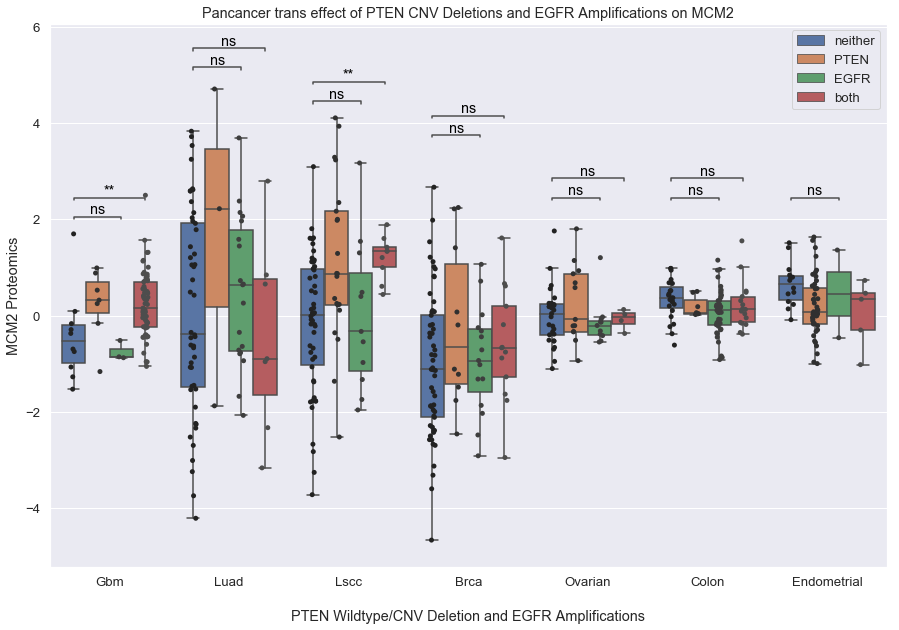

In [40]:
gene = 'PTEN'
plt.rcParams['figure.figsize']=(15,10) #size of plot
sns.set(font_scale = 1.2)

boxplot = sns.boxplot(x='cancer', y=t_gene+"_proteomics", data = df6, hue = 'dual_mut_status',
                      hue_order = ["neither", "PTEN", 'EGFR','both'], showfliers = False)    
boxplot.set_title('Pancancer trans effect of PTEN CNV Deletions and EGFR Amplifications on '+t_gene)
boxplot = sns.stripplot(x='cancer', y=t_gene+"_proteomics", data = df6, jitter = True, 
                           color = ".3", hue = 'dual_mut_status', 
                        hue_order = ["neither", "PTEN", 'EGFR','both'],dodge = True)
boxplot.set(xlabel = "\n"+gene+" Wildtype/CNV Deletion and EGFR Amplifications", ylabel = t_gene+' Proteomics')

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:4], labels[0:4])


# Create significance symbols:
# * P ≤ 0.05   ** P ≤ 0.01   *** P ≤ 0.001 

pvals = [gp, lp, lsp, bp, op, cp, ep] # same order as appended in long df
symbols = {}

for p in pvals:
    if p <= 0.001:
        symbols[p] = '***'
    elif p <= 0.01:
        symbols[p] = '**'
    elif p <= .05:
        symbols[p] = '*'
    else:
        symbols[p] = 'ns'
#print(symbols)

format_pval_annotation(symbols[gp], -.3, .1, 2) # Gbm
format_pval_annotation(symbols[lp], .7, 1.1, 5.1) # Luad
format_pval_annotation(symbols[lsp], 1.7, 2.1, 4.4) # Lscc
format_pval_annotation(symbols[bp], 2.7, 3.1, 3.7) # Brca
format_pval_annotation(symbols[op], 3.7, 4.1, 2.4) # Ovarian
format_pval_annotation(symbols[cp], 4.7, 5.1, 2.4)  # Colon
format_pval_annotation(symbols[ep], 5.7, 6.1, 2.4) # Endometrial

# both vs neither
dual_pvals = [dual_gp, dual_lp, dual_lsp, dual_bp, dual_op, dual_cp, dual_ep] # same order as appended in long df
d_symbols = {}

for p in dual_pvals:
    if p <= 0.001:
        d_symbols[p] = '***'
    elif p <= 0.01:
        d_symbols[p] = '**'
    elif p <= .05:
        d_symbols[p] = '*'
    else:
        d_symbols[p] = 'ns'
#print(symbols)

format_pval_annotation(d_symbols[dual_gp], -.3, .3, 2.4) # Gbm
format_pval_annotation(d_symbols[dual_lp], .7, 1.3, 5.5) # Luad
format_pval_annotation(d_symbols[dual_lsp], 1.7, 2.3, 4.8) # Lscc
format_pval_annotation(d_symbols[dual_bp], 2.7, 3.3, 4.1) # Brca
format_pval_annotation(d_symbols[dual_op], 3.7, 4.3, 2.8) # Ovarian
format_pval_annotation(d_symbols[dual_cp], 4.7, 5.3, 2.8)  # Colon
#format_pval_annotation(d_symbols[dual_ep], 5.7, 6.3, 2.8) # Endometrial # not enough samples

plt.show()
plt.clf()
plt.close()

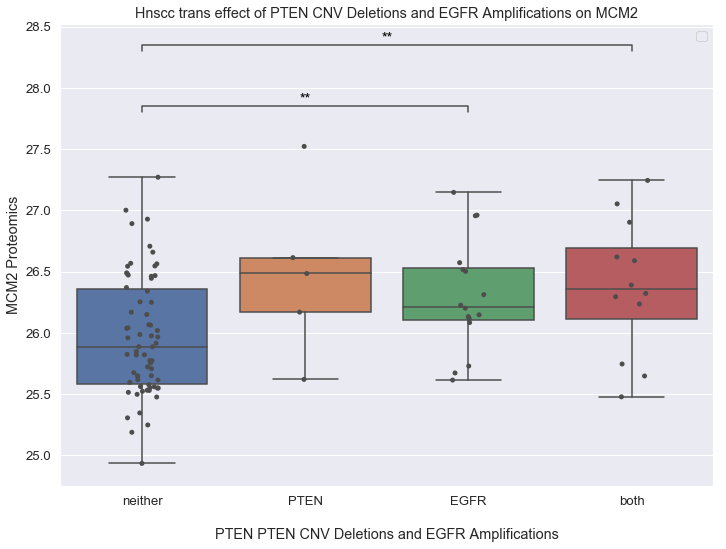

In [41]:
gene = 'PTEN'
plt.rcParams['figure.figsize']=(11.7,8.5) #size of plot
sns.set(font_scale = 1.2)

boxplot = sns.boxplot(x='dual_mut_status', y=t_gene+"_proteomics", data = h_df, 
                      order = ["neither", "PTEN", 'EGFR','both'], showfliers = False)    
boxplot.set_title('Hnscc trans effect of PTEN CNV Deletions and EGFR Amplifications on '+t_gene)
boxplot = sns.stripplot(x='dual_mut_status', y=t_gene+"_proteomics", data = h_df, jitter = True, 
                           color = ".3", order = ["neither", "PTEN", 'EGFR','both'],dodge = True)
boxplot.set(xlabel = "\n"+gene+" PTEN CNV Deletions and EGFR Amplifications", ylabel = t_gene+' Proteomics')

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:4], labels[0:4])


# Create significance symbols:
# * P ≤ 0.05   ** P ≤ 0.01   *** P ≤ 0.001 

pvals = [hp, dual_hp] # same order as appended in long df
symbols = {}

for p in pvals:
    if p <= 0.001:
        symbols[p] = '***'
    elif p <= 0.01:
        symbols[p] = '**'
    elif p <= .05:
        symbols[p] = '*'
    else:
        symbols[p] = 'ns'
#print(symbols)

format_pval_annotation(symbols[hp], 0, 2.0, 27.8) 
format_pval_annotation(symbols[dual_hp], 0, 3.0, 28.3) 


plt.show()
plt.clf()
plt.close()

In [27]:
# Save figure
#fig = boxplot.get_figure()
#fig.savefig(".png")